# Домашняя работа 1


## Описание

В этой домашней работе вы должны применить знания по многослойным нейроным сетям 

- Для простоты попробуем обучить сначала однослойный перцептрон
- Решать будем простую задачу бинарной классификации
- Датасет игрушечный -  `load_data()` загружает его


In [204]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

## Загрузка данных

In [205]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [206]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


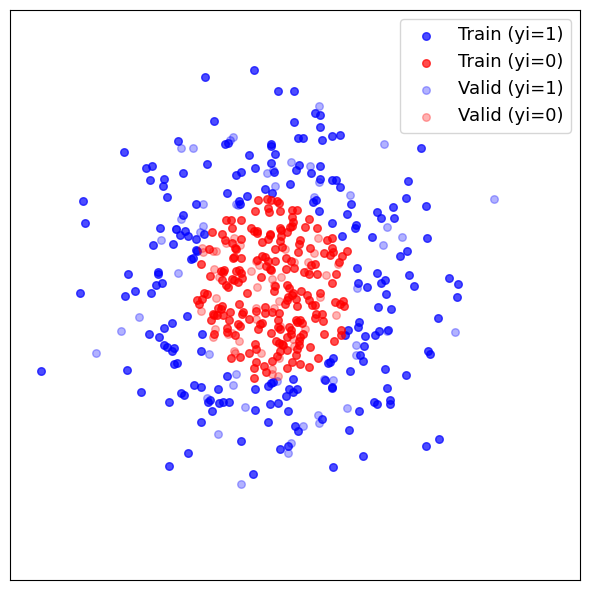

In [207]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## Класс нейросети

Вам необходимо описать простую полносвязную многослойную нейронную сеть 

In [208]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 5)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(5, 1)
        self.a2 = nn.Sigmoid()

    def forward(self, x):
        x = self.a1(self.l1(x))
        x = self.a2(self.l2(x))
        return x

##  Функция обучения сети

In [209]:
import copy
import tqdm

def train_model(model: nn.Module,
                loss_fn,
                optimizer_class,
                n_epochs: int,
                batch_size: int,
                lr,
                X_train,
                y_train,
                X_val=None,
                y_val=None):

    # Prepare data
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size, shuffle=True)

    if (X_val is not None) and (y_val is not None):
        X_val = torch.FloatTensor(X_val)
        y_val = torch.FloatTensor(y_val)

    optimizer = optimizer_class(model.parameters(), lr)
    
    # Hold the best model
    best_acc = - np.inf
    best_weights = None
    loss_history = []
    acc_history = []

    with tqdm.tqdm(range(n_epochs), unit=" epoch") as n_epochs_wrapper:
        for _ in n_epochs_wrapper:

            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()

                y_pred = model(X_batch)
                loss = loss_fn(y_pred.squeeze(), y_batch)

                loss.backward()

                optimizer.step()

            if (X_val is None) or (y_val is None):
                continue

            model.eval()
            y_pred = model(X_val).squeeze()
            loss_history.append(loss_fn(y_pred, y_val).item())
            
            acc = (y_pred.round() == y_val).float().mean()
            acc_history.append(acc)
            n_epochs_wrapper.set_postfix(
                loss=float(loss_history[-1]),
                acc=float(acc)
            )

            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
            if acc > 0.999:
                break

    print('Best accuracy:', float(best_acc))
    model.load_state_dict(best_weights)

    return loss_history, acc_history

### Обучите сеть

Обучите сеть три раза - с тремя разными оптимизиторами
Не забудьте переинициализировать сеть заного перед каждой загрузкой. Убедитесь, что вы верно передали параметры сети в оптимизатор

**Подсказка** Лучше объявить три независимых объекта - модель1, модель2 и модель3

In [210]:
def prepare_and_train(model_class, opt, lr):
  """Helper function for tests"""
  criterion = nn.MSELoss()
  model = model_class()
  loss_history, acc_history = train_model(model,
                                          criterion,
                                          opt,
                                          n_epochs=1000,
                                          batch_size=64,
                                          lr=lr,
                                          X_train=X_train,
                                          y_train=y_train,
                                          X_val=X_test,
                                          y_val=y_test)
  return model, loss_history, acc_history


In [211]:
# optimizer_name -> params{optimizer class, lr}
optims = {'SGD': {'opt': torch.optim.SGD, 'lr': 0.01},
          'Adam': {'opt': torch.optim.Adam, 'lr': 0.001},
          'RMSprop': {'opt': torch.optim.RMSprop, 'lr': 0.001}}

# optimizer_name -> results{'models', 'loss', 'acc'}
result_nn = {}

for name, params in optims.items():
  print('Train', name)
  model, loss_history, acc_history = prepare_and_train(NeuralNetwork, **params)
  result_nn[name] = {
      'model': model,
      'loss': loss_history,
      'acc': acc_history
  }

Train SGD


100%|██████████| 1000/1000 [00:08<00:00, 116.45 epoch/s, acc=0.61, loss=0.226]


Best accuracy: 0.6299999952316284
Train Adam


100%|██████████| 1000/1000 [00:09<00:00, 103.63 epoch/s, acc=0.97, loss=0.0398]


Best accuracy: 0.9700000286102295
Train RMSprop


100%|██████████| 1000/1000 [00:08<00:00, 117.58 epoch/s, acc=0.98, loss=0.0499]

Best accuracy: 0.9800000190734863


### А теперь посмотрим на графики лоссов

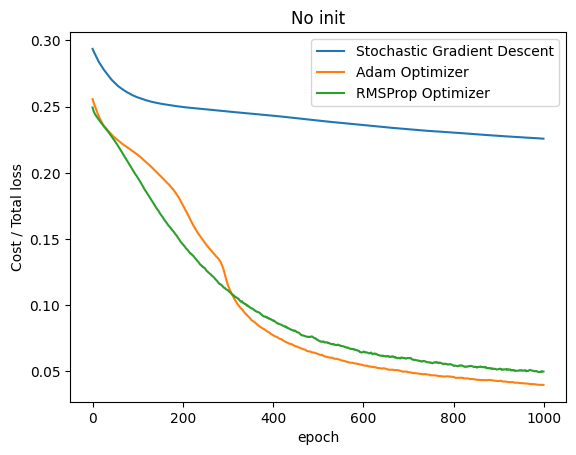

In [212]:
plt.plot(result_nn['SGD']['loss'], label = "Stochastic Gradient Descent")
plt.plot(result_nn['Adam']['loss'], label = "Adam Optimizer")
plt.plot(result_nn['RMSprop']['loss'], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost / Total loss')
plt.title('No init')
plt.legend()
plt.show()

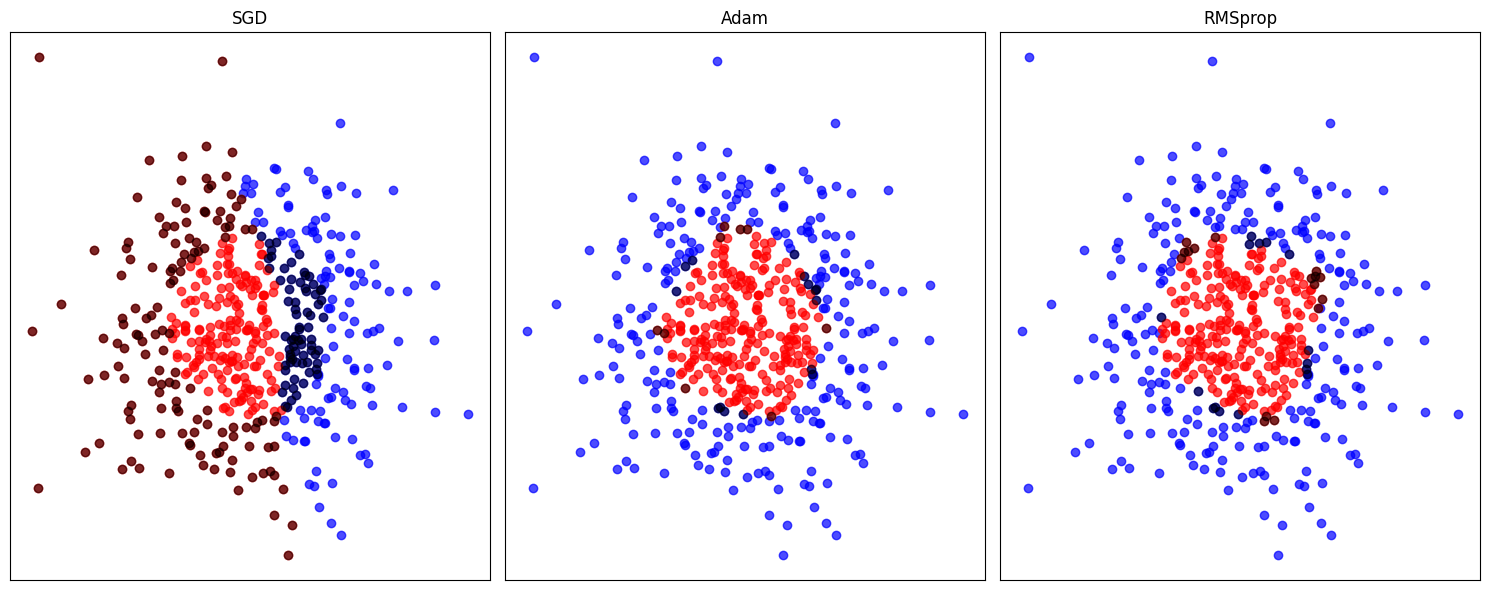

In [213]:
# Visualize models quality on another dataset
v_data = make_gaussian_quantiles(
    mean=None,
    cov=0.7,
    n_samples=500,
    n_features=2,
    n_classes=2,
    shuffle=True,
    random_state=666,
)
X_v, y_v = v_data
plt.figure(figsize=(15, 6))
for i, (name, res) in enumerate(result_nn.items()):
    model = res['model']
    preds = np.where(model(torch.FloatTensor(
        X_v)).detach().numpy().reshape(-1) > 0.5, 1, 0)

    plt.subplot(1, 3, 1+i)
    X_1 = X_v[preds == 1]
    X_0 = X_v[preds == 0]
    X_False = X_v[preds != y_v]
    plt.scatter(X_1[:, 0], X_1[:, 1], c="blue",
                label='predicted (yi=1)', alpha=0.7)
    plt.scatter(X_0[:, 0], X_0[:, 1], c="red",
                label='predicted (yi=0)', alpha=0.7)
    plt.scatter(X_False[:, 0], X_False[:, 1], c="black",
                label='predicted (yi=0)', alpha=0.5)
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout()

    plt.title(name)

### Инициализация

Теперь проинициализируйте веса в вашей модели: случайно и Ксавьером. Сравните результат

In [214]:
import torch.nn.init as init


class NeuralNetworkXavier(NeuralNetwork):
    def __init__(self):
        super().__init__()
        init.xavier_uniform_(self.l1.weight)
        init.xavier_uniform_(self.l2.weight)

In [215]:
# optimizer_name -> params{optimizer class, lr}
optims = {'SGD': {'opt': torch.optim.SGD, 'lr': 0.01},
          'Adam': {'opt': torch.optim.Adam, 'lr': 0.001},
          'RMSprop': {'opt': torch.optim.RMSprop, 'lr': 0.001}}

# optimizer_name -> results{'models', 'loss', 'acc'}
result_nnx = {}
print('Xavier')
for name, params in optims.items():
  print('Train', name)
  model, loss_history, acc_history = prepare_and_train(
      NeuralNetworkXavier, **params)
  result_nnx[name] = {
      'model': model,
      'loss': loss_history,
      'acc': acc_history
  }

Xavier
Train SGD


100%|██████████| 1000/1000 [00:08<00:00, 122.37 epoch/s, acc=0.8, loss=0.154]


Best accuracy: 0.800000011920929
Train Adam


100%|██████████| 1000/1000 [00:13<00:00, 74.57 epoch/s, acc=0.97, loss=0.0379]


Best accuracy: 0.9900000095367432
Train RMSprop


100%|██████████| 1000/1000 [00:08<00:00, 114.08 epoch/s, acc=0.79, loss=0.145]


Best accuracy: 0.8100000023841858


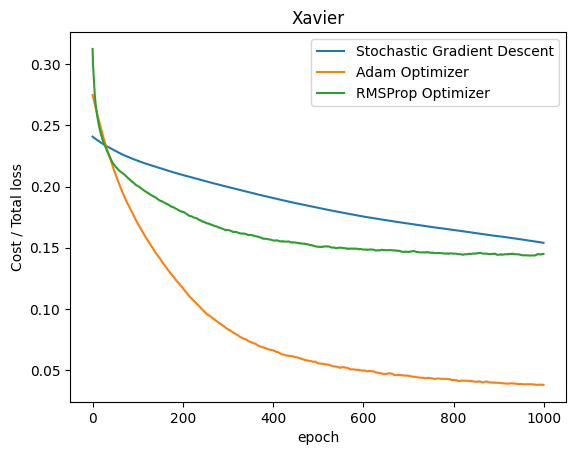

In [216]:
plt.plot(result_nnx['SGD']['loss'], label = "Stochastic Gradient Descent")
plt.plot(result_nnx['Adam']['loss'], label = "Adam Optimizer")
plt.plot(result_nnx['RMSprop']['loss'], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost / Total loss')
plt.legend()
plt.title('Xavier')
plt.show()

In [217]:
import torch.nn.init as init


class NeuralNetworkRandom(NeuralNetwork):
    def __init__(self):
        super().__init__()
        init.normal_(self.l1.weight)
        init.normal_(self.l2.weight)

In [218]:
# optimizer_name -> params{optimizer class, lr}
optims = {'SGD': {'opt': torch.optim.SGD, 'lr': 0.01},
          'Adam': {'opt': torch.optim.Adam, 'lr': 0.001},
          'RMSprop': {'opt': torch.optim.RMSprop, 'lr': 0.001}}

# optimizer_name -> results{'models', 'loss', 'acc'}
result_nnr = {}
print('Random(normal)')
for name, params in optims.items():
  print('Train', name)
  model, loss_history, acc_history = prepare_and_train(
      NeuralNetworkRandom, **params)
  result_nnr[name] = {
      'model': model,
      'loss': loss_history,
      'acc': acc_history
  }

Random(normal)
Train SGD


100%|██████████| 1000/1000 [00:08<00:00, 118.88 epoch/s, acc=0.74, loss=0.252]


Best accuracy: 0.7400000095367432
Train Adam


100%|██████████| 1000/1000 [00:09<00:00, 103.99 epoch/s, acc=0.93, loss=0.0502]


Best accuracy: 0.949999988079071
Train RMSprop


100%|██████████| 1000/1000 [00:08<00:00, 117.91 epoch/s, acc=0.95, loss=0.0438]


Best accuracy: 0.949999988079071


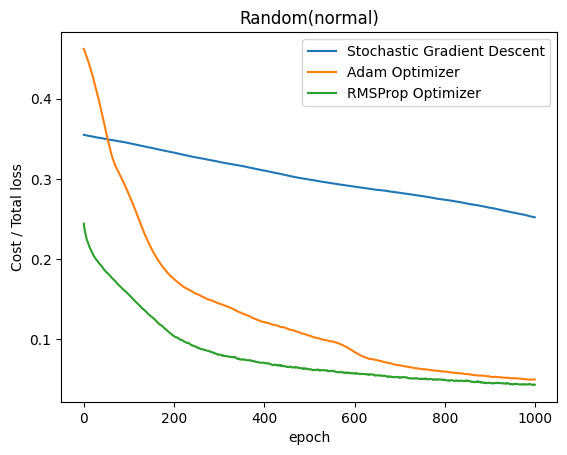

In [219]:
plt.plot(result_nnr['SGD']['loss'], label = "Stochastic Gradient Descent")
plt.plot(result_nnr['Adam']['loss'], label = "Adam Optimizer")
plt.plot(result_nnr['RMSprop']['loss'], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost / Total loss')
plt.legend()
plt.title('Random(normal)')
plt.show()

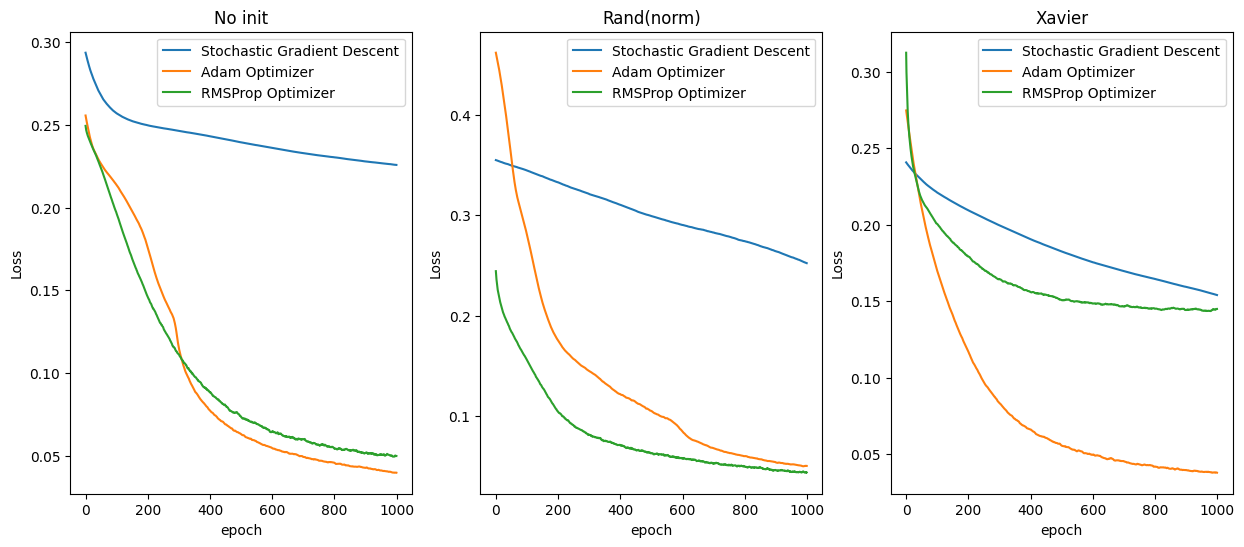

In [220]:
def plot_loss(result, title):
  plt.plot(result['SGD']['loss'], label = "Stochastic Gradient Descent")
  plt.plot(result['Adam']['loss'], label = "Adam Optimizer")
  plt.plot(result['RMSprop']['loss'], label = 'RMSProp Optimizer')
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title(title)

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plot_loss(result_nn, 'No init')
plt.subplot(1, 3, 2)
plot_loss(result_nnr, 'Rand(norm)')
plt.subplot(1, 3, 3)
plot_loss(result_nnx, 'Xavier')



## А теперь решите многоклассовую проблему

Продемонстрируйте свои знания - решите более сложную проблему
Попробуйте разные инициализации, методы оптимизации и кол-во нейронов.

Найдите лучшие параметры через KFold

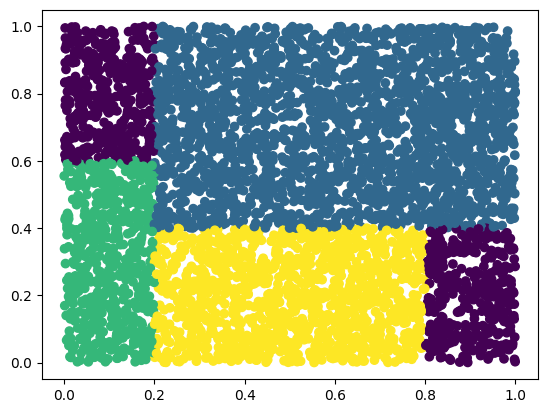

In [221]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)
        
target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

# train = data[:800]
# valid = data[800:900]
# test = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [222]:
class AdvancedModel(nn.Module):
    def __init__(self, n_in: int, n_hidden: int, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, n_hidden)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(n_hidden, n_out)
        self.a2 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.a1(self.l1(x))
        x = self.a2(self.l2(x))
        return x
    

class AdvancedModelRandom(AdvancedModel):
    def __init__(self, n_in: int, n_hidden: int, n_out):
        super().__init__(n_in, n_hidden, n_out)
        init.normal_(self.l1.weight)
        init.normal_(self.l2.weight)
        
        
class AdvancedModelXavier(AdvancedModel):
    def __init__(self, n_in: int, n_hidden: int, n_out):
        super().__init__(n_in, n_hidden, n_out)
        init.xavier_uniform_(self.l1.weight)
        init.xavier_uniform_(self.l2.weight)


In [223]:
X_train = points[:900]
y_train = target[:900]

X_test = points[900:]
y_test = target[900:]

n_input = X_train.shape[1]
n_output = 4

In [224]:
import copy
import tqdm

def train_adv_model(model: nn.Module,
                loss_fn,
                optimizer_class,
                n_epochs: int,
                batch_size: int,
                lr,
                X_train,
                y_train,
                X_val=None,
                y_val=None):

    # Prepare data
    X_train = torch.FloatTensor(X_train)
    y_train = torch.LongTensor(y_train)
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size, shuffle=True)

    if (X_val is not None) and (y_val is not None):
        X_val = torch.FloatTensor(X_val)
        y_val = torch.LongTensor(y_val)

    optimizer = optimizer_class(model.parameters(), lr)
    
    # Hold the best model
    best_acc = - np.inf
    best_weights = None
    acc_history = []

    for _ in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            _, y_pred = torch.max(model(X_val), 1)
            
            acc = (y_pred == y_val).float().mean()
            acc_history.append(acc)

            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
            if acc > 0.999:
                break
    model.load_state_dict(best_weights)

    return float(best_acc)

In [225]:
import itertools
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)


class Params():
    def __init__(self, init_method: str, n_hidden: int, lr: int, opt, w = None):
        self.init_method = init_method
        self.n_hidden = n_hidden
        self.lr = lr
        self.opt = opt
        self.w = w

    def __str__(self):
        return f'init_method: {self.init_method}, n_hidden: {self.n_hidden}, lr: {self.lr}, opt: {self.opt.__name__}'


n_hidden_set = [32, 64, 128]
lr_set = [0.01, 0.001, 0.0001]
optimizer_set = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop]
init_method_set = ['xavier', 'rand']
params = itertools.product(
    init_method_set, n_hidden_set, lr_set, optimizer_set)

best_acc = -np.inf
best_params = None

for init_m, n_hidden, lr, opt in params:
    curr_p = Params(init_m, n_hidden, lr, opt)
    acc = 0
    m_cl = AdvancedModelXavier if init_m == 'xavier' else AdvancedModelRandom
    for train_idx, val_idx in kf.split(X_train):
        criterion = nn.CrossEntropyLoss()

        model = m_cl(n_input, n_hidden, n_output)

        acc += train_adv_model(model,
                               criterion,
                               opt,
                               n_epochs=10,
                               batch_size=64,
                               lr=lr,
                               X_train=X_train[train_idx],
                               y_train=y_train[train_idx].numpy(),
                               X_val=X_train[val_idx],
                               y_val=y_train[val_idx].numpy())
    acc /= 5
    print(f'{curr_p} \tacc: {acc:.4f}')

    if acc > best_acc:
        best_acc = acc
        best_params = curr_p
        best_params.w = copy.deepcopy(model.state_dict())
        # print('new best:', best_params)

print(f'\nBEST: {best_params} \tacc: {best_acc:.4f}')

init_method: xavier, n_hidden: 32, lr: 0.01, opt: SGD 	acc: 0.4844
init_method: xavier, n_hidden: 32, lr: 0.01, opt: Adam 	acc: 0.7600
init_method: xavier, n_hidden: 32, lr: 0.01, opt: RMSprop 	acc: 0.8467
init_method: xavier, n_hidden: 32, lr: 0.001, opt: SGD 	acc: 0.1678
init_method: xavier, n_hidden: 32, lr: 0.001, opt: Adam 	acc: 0.5167
init_method: xavier, n_hidden: 32, lr: 0.001, opt: RMSprop 	acc: 0.4889
init_method: xavier, n_hidden: 32, lr: 0.0001, opt: SGD 	acc: 0.2122
init_method: xavier, n_hidden: 32, lr: 0.0001, opt: Adam 	acc: 0.3722
init_method: xavier, n_hidden: 32, lr: 0.0001, opt: RMSprop 	acc: 0.3289
init_method: xavier, n_hidden: 64, lr: 0.01, opt: SGD 	acc: 0.5133
init_method: xavier, n_hidden: 64, lr: 0.01, opt: Adam 	acc: 0.7344
init_method: xavier, n_hidden: 64, lr: 0.01, opt: RMSprop 	acc: 0.7956
init_method: xavier, n_hidden: 64, lr: 0.001, opt: SGD 	acc: 0.2778
init_method: xavier, n_hidden: 64, lr: 0.001, opt: Adam 	acc: 0.5200
init_method: xavier, n_hidden:

In [226]:
m_cl = AdvancedModelXavier if best_params.init_method == 'xavier' else AdvancedModelRandom
model = m_cl(n_input, best_params.n_hidden, n_output)
train_adv_model(model,
                nn.CrossEntropyLoss(),
                best_params.opt,
                n_epochs=100,
                batch_size=64,
                lr=best_params.lr,
                X_train=X_train,
                y_train=y_train.numpy(),
                X_val=X_train,
                y_val=y_train.numpy())

0.898888885974884

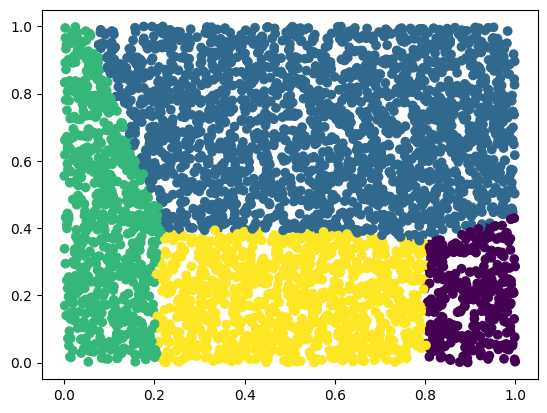

In [227]:
_, y_pred = torch.max(model(X_test), 1)
plt.scatter(X_test[:,0],X_test[:,1],c = y_pred)
plt.show()

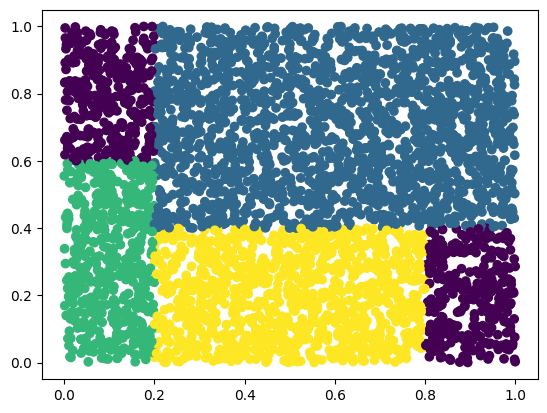

In [228]:
plt.scatter(X_test[:,0],X_test[:,1],c = y_test)
plt.show()

## (Почти) Боевая задача
 
Перед вами датасет с классификацией алкоголя. Продемонстрируйте свои знания и решите задачу многоклассовой классификации

In [229]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [230]:
df['target'].value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

In [231]:
df.isnull().sum().any()

False

In [232]:
from sklearn.preprocessing import StandardScaler

# Преобразование датасета в тензор
data = df[df.columns[:-1]].values
target = df.target

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(data)

X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(target, dtype=torch.long)

# Разбиение на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [233]:
import itertools
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)


class Params():
    def __init__(self, init_method: str, n_hidden: int, lr: int, opt, w = None):
        self.init_method = init_method
        self.n_hidden = n_hidden
        self.lr = lr
        self.opt = opt
        self.w = w

    def __str__(self):
        return f'init_method: {self.init_method}, n_hidden: {self.n_hidden}, lr: {self.lr}, opt: {self.opt.__name__}'


n_hidden_set = [32, 64, 128]
lr_set = [0.01, 0.001, 0.0001]
optimizer_set = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop]
init_method_set = ['xavier', 'rand']
params = itertools.product(
    init_method_set, n_hidden_set, lr_set, optimizer_set)

best_acc = -np.inf
best_params = None

for init_m, n_hidden, lr, opt in params:
    curr_p = Params(init_m, n_hidden, lr, opt)
    acc = 0
    m_cl = AdvancedModelXavier if init_m == 'xavier' else AdvancedModelRandom
    for train_idx, val_idx in kf.split(X_train):
        criterion = nn.CrossEntropyLoss()

        model = m_cl(n_input, n_hidden, n_output)

        acc += train_adv_model(model,
                               criterion,
                               opt,
                               n_epochs=10,
                               batch_size=64,
                               lr=lr,
                               X_train=X_train[train_idx],
                               y_train=y_train[train_idx].numpy(),
                               X_val=X_train[val_idx],
                               y_val=y_train[val_idx].numpy())
    acc /= 5
    print(f'{curr_p} \tacc: {acc:.4f}')

    if acc > best_acc:
        best_acc = acc
        best_params = curr_p
        best_params.w = copy.deepcopy(model.state_dict())
        # print('new best:', best_params)

print(f'\nBEST: {best_params} \tacc: {best_acc:.4f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x13 and 2x32)

In [ ]:
# на сегодня все...